## Setup

In [1]:
import sys
import os
sys.path.append(os.path.join("..", ".."))
import model
import numpy as np
import matplotlib.pyplot as plt

## Data Generation

In [14]:
shapefile = os.path.join("..", "..", "data", "argentina_shapefile")
N0 = 1000
T = 200
step_fraction = 40
seed=39
distance_cutoff = 0.75

if False:
    import geopandas
    import pandas as pd
    sim = dict(map=geopandas.read_file(shapefile))
    sim["location"] = model.sim.location.simulate_position(
        sim["map"]["geometry"], N0=N0, T=T, seed=seed, step_fraction=step_fraction
    )
    sim["patients"] = pd.DataFrame({"patient": np.unique(sim["location"]["patient"])})
    sim["dates"] = pd.DataFrame({"date": np.unique(sim["location"]["date"])})

    distance_cutoff = 1
    model.sim.contacts.np = np
    model.sim.contacts.pd = pd
    sim["contacts"] = model.sim.contacts.calculate_contacts(sim, distance_cutoff=distance_cutoff)

    distance_cutoff = 0.75
    sim["contacts"] = sim["contacts"].loc[sim["contacts"]['distance'] < distance_cutoff]
    model.sim.contacts.calculate_Nc(sim)

In [ ]:
try:
    raise FileNotFoundError
    sim = model.sim.load_pickle()
except FileNotFoundError:
    sim = model.sim.simulate(
        shapefile=shapefile, 
        N0=N0,
        T=T, 
        N_infected=1, 
        step_fraction=step_fraction, 
        distance_cutoff=distance_cutoff, 
        seed=seed
    )

Calculating positions...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 19.5min


In [51]:
if True:
    sim["states"], sim["tests"] = model.sim.state.simulate_states(sim, N_infected=1)
    sim["hospital"] = model.sim.state.get_first_occurrence(sim["states"], 6)
    sim["deaths"] = model.sim.state.get_first_occurrence(sim["states"], 8)

Calculating states...
t = 0; 1 infectious; 6 exposed; 999 susceptible; 0 dead
t = 20; 3 infectious; 16 exposed; 990 susceptible; 0 dead
t = 40; 28 infectious; 181 exposed; 903 susceptible; 0 dead
t = 60; 54 infectious; 341 exposed; 756 susceptible; 0 dead
t = 80; 46 infectious; 338 exposed; 620 susceptible; 2 dead
t = 100; 50 infectious; 311 exposed; 499 susceptible; 3 dead
t = 120; 25 infectious; 189 exposed; 426 susceptible; 5 dead
t = 140; 14 infectious; 94 exposed; 380 susceptible; 5 dead
t = 160; 22 infectious; 136 exposed; 342 susceptible; 5 dead
t = 180; 12 infectious; 62 exposed; 311 susceptible; 5 dead
Calculated states in 5.07 seconds.


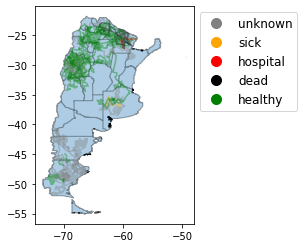

<Figure size 432x288 with 0 Axes>

In [53]:
model.sim.plot_sim(sim, patients = np.arange(10), color='known_status')
plt.savefig("sample_known_status.png")

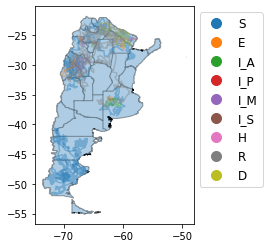

<Figure size 432x288 with 0 Axes>

In [54]:
model.sim.plot_sim(sim, patients = np.arange(10), color='state')
plt.savefig("sample_true_state.png")

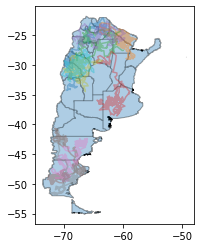

<Figure size 432x288 with 0 Axes>

In [44]:
model.sim.plot_sim(sim, patients = np.arange(10), color='patient')
plt.savefig("sample_patient_id.png")

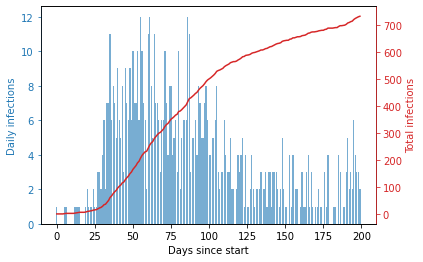

In [52]:
model.sim.plot_infections(sim)
plt.savefig("infection_rate.png")

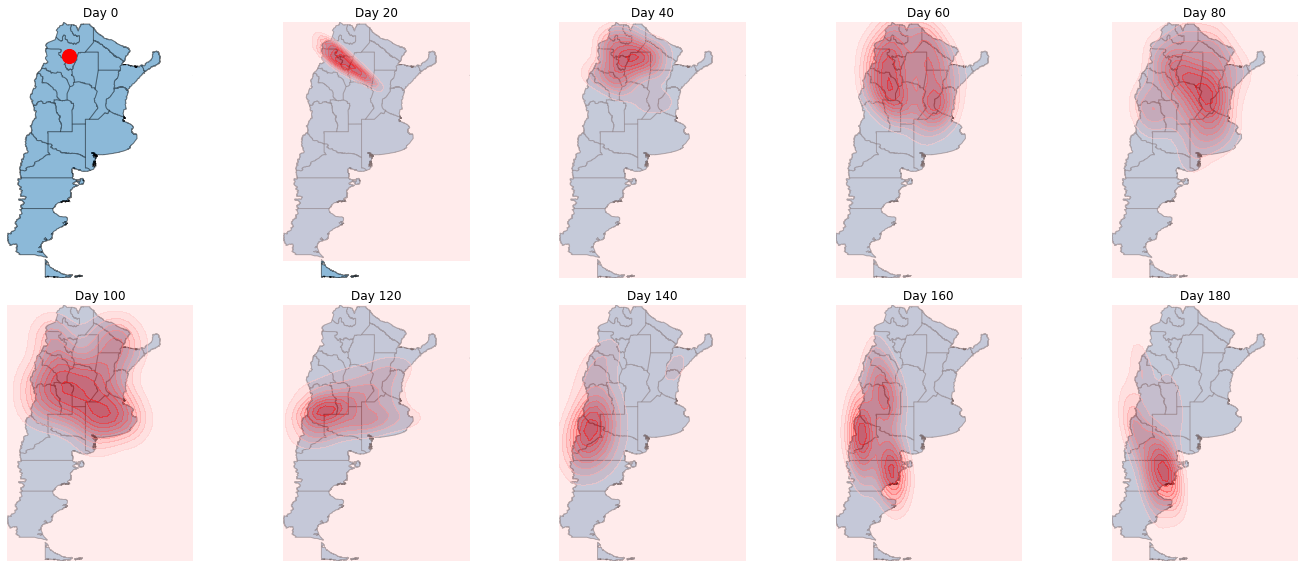

In [55]:
model.sim.plot_heatmap(sim)
plt.savefig("infectious_population_density.png")

In [56]:
sim['location'].head()

,patient,date,latitude,longitude
0,0,0,-66.624208,-24.008816
1,0,1,-65.888580,-23.841946
2,0,2,-65.480436,-22.907470
3,0,3,-64.701645,-23.315005
4,0,4,-64.305449,-23.378123


In [57]:
sim['tests'].head()

,patient,date,result
0,51,0,False
1,288,0,False
2,473,0,False
3,629,0,False
4,697,0,False


In [58]:
sim['hospital'].head()

,patient,date
12,313,48
28,682,54
31,805,56
6,225,58
16,387,58


In [59]:
sim['deaths'].head()

,patient,date
1,176,72
4,805,74
3,486,100
0,1,104
2,225,112


In [60]:
model.sim.io.save_pickle(sim)
#model.sim.io.save_csv(sim)

## Disease spread modeling

For model specification, see the [README](../../README.md)

In [61]:
import pandas as pd
negative_tests = sim['tests'].loc[np.logical_not(sim['tests']['result'])][['patient', 'date']]
negative_tests['outcome'] = 'negative'
positive_tests = sim['tests'].loc[sim['tests']['result']][['patient', 'date']]
positive_tests['outcome'] = 'positive'
hospital = sim['hospital'].copy()
hospital['outcome'] = 'hospital'
deaths = sim['deaths'].copy()
deaths['outcome'] = 'dead'
outcomes = pd.concat([positive_tests, negative_tests, hospital, deaths])
outcomes

,patient,date,outcome
4,272,4,positive
5,525,5,positive
1,525,6,positive
4,525,7,positive
5,525,8,positive
...,...,...,...
1,176,72,dead
4,805,74,dead
3,486,100,dead
0,1,104,dead


In [62]:
from joblib import Parallel, delayed

def calculate_centrality(p, contacts):
    return np.sum([np.logical_or(contacts['patient1'] == p, contacts['patient2']==p)])

centrality = np.array(Parallel(10)(delayed(calculate_centrality)(p, sim['contacts'])
                       for p in sim['patients']['patient']))

In [63]:
centrality = pd.DataFrame({'centrality':centrality})
centrality.index.name = 'patient'

In [64]:
# set the initial state -- at present everyone is probably healthy
state = model.model.initial_state(sim)
state

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [65]:
# evaluate contacts each day and update the model
curr_date = 70
save_states = np.arange(10)
saved_states = {}
for date in sim["dates"]["date"]:
    state = model.model.next_state(sim, state, date, distance_cutoff=0.006)
    if date in save_states + curr_date:
        saved_states[date - curr_date] = state
    elif date > np.max(save_states) + curr_date:
        break

In [66]:
BETA0 = model.constants.beta0
output = pd.DataFrame(columns = ['patient', 'date', 'state', 'scenario', 'prob'])

In [67]:
for i in save_states:
    for j, name in model.model.STATES.items():
        output = pd.concat([output, pd.DataFrame({
            'id':np.arange(saved_states[i].shape[0]),
            'date':i, 
            'state':name, 
            'scenario':'moderate', 
            'prob':saved_states[i][:,j]
        })])

In [68]:
model.constants.beta0 = BETA0 * 0.8
state = model.model.initial_state(sim)
for date in sim["dates"]["date"]:
    state = model.model.next_state(sim, state, date, distance_cutoff=0.006)
    if date in save_states + curr_date:
        saved_states[date - curr_date] = state
    elif date > np.max(save_states) + curr_date:
        break

for i in save_states:
    for j, name in model.model.STATES.items():
        output = pd.concat([output, pd.DataFrame({
            'id':np.arange(saved_states[i].shape[0]),
            'date':i, 
            'state':name, 
            'scenario':'optimistic', 
            'prob':saved_states[i][:,j]
        })])

In [69]:
model.constants.beta0 = BETA0 * 1.2
state = model.model.initial_state(sim)
for date in sim["dates"]["date"]:
    state = model.model.next_state(sim, state, date, distance_cutoff=0.006)
    if date in save_states + curr_date:
        saved_states[date - curr_date] = state
    elif date > np.max(save_states) + curr_date:
        break

for i in save_states:
    for j, name in model.model.STATES.items():
        output = pd.concat([output, pd.DataFrame({
            'id':np.arange(saved_states[i].shape[0]),
            'date':i, 
            'state':name, 
            'scenario':'pessimistic', 
            'prob':saved_states[i][:,j]
        })])

In [70]:
sim['location'].to_csv("location.csv")
sim['contacts'].to_csv("contacts.csv")
outcomes.to_csv("outcomes.csv")
output.to_csv("output.csv")
centrality.to_csv("centrality.csv")

In [14]:
output.loc[(output['id'] == 989) & (output['date'] == 10) & (output['state'] == 'D')]

,id,date,state,scenario,prob
989,989,10,D,moderate,0.004917
989,989,10,D,optimistic,0.003410
989,989,10,D,pessimistic,0.006235


In [68]:
# print the final model state
with np.printoptions(threshold=np.inf):
    print(state.round(3))

[[0.    0.    0.    0.    0.    0.    0.    0.8   0.2  ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.003 0.    0.01  0.969 0.018]
 [0.    0.    0.    0.    0.    0.    0.001 0.979 0.02 ]
 [0.    0.    0.    0.    0.    0.    0.002 0.978 0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.166 0.667 0.167]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.001 0.979 0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.014 0.789 0.197]
 [0.    0.    0.    0.    0.   

In [69]:
np.argmax(state, axis=1)

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 8, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7,
       7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [70]:
sim['states'][:,-1]

array([7., 7., 7., 7., 0., 7., 7., 7., 0., 7., 7., 7., 7., 7., 7., 7., 7.,
       0., 0., 7., 7., 7., 7., 0., 7., 0., 7., 0., 7., 7., 7., 7., 7., 0.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 0., 7., 0., 7., 7., 7., 0., 7.,
       5., 7., 7., 7., 7., 0., 7., 7., 7., 7., 7., 7., 7., 7., 7., 0., 7.,
       7., 7., 7., 0., 0., 7., 7., 7., 0., 0., 7., 7., 7., 0., 7., 7., 7.,
       0., 0., 7., 7., 7., 7., 0., 0., 0., 7., 7., 7., 0., 7., 7., 4., 7.,
       7., 0., 7., 7., 0., 7., 7., 7., 7., 7., 0., 0., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 8., 0., 0., 8., 7., 7., 0., 7., 7.,
       0., 7., 7., 7., 0., 7., 0., 7., 7., 7., 0., 7., 7., 0., 7., 7., 0.,
       7., 7., 0., 7., 2., 7., 0., 7., 0., 0., 0., 7., 7., 0., 0., 7., 0.,
       0., 7., 7., 7., 0., 0., 7., 7., 7., 7., 7., 7., 7., 7., 0., 0., 7.,
       0., 0., 7., 0., 7., 0., 7., 0., 7., 7., 7., 7., 7., 7., 0., 0., 7.,
       7., 7., 7., 7., 7., 7., 0., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 0., 7., 7.